# NetLogo Results Analysis for the Compound Events Model

## 1. Experiment Setup


- max_effectiveness (policy lever) | [2 - 6 - 10]

If bands were to have invested in their efficiency to hunt and gather, this could create a higher survivability. This parameter will show the relative importance of skill.


- cooperation_radius (policy_lever) | [1 - 3 - 5]

This parameter focuses on the cooperation and sharing of knowledge between bands. It will show the relative importance of working together and acquiring knowledge.


- maximum_days_moving (policy lever) | [10 - 30 - 50]

This parameter will show the relative importance of the ability to move around easily.

- start_event | [60 - 120 - 240]

Altering the starting time of the volcano eruption will show how important it is for bands to be fully prepared for such a shock. Also, the situation where no volcano erupted at all will be analysed.

- GISP2_trend | [On - Off]
Turning the existence of climate change on or off will show the impact of the stress of low temperature on the survivability of the bands. Together with the volcano eruption, this will create 4 possible situations: stable model, only climate change, only eruption, compound event.


Out of these parameters, a full facotorial experiment setup will be run. There will be 10 replications for each set of parameter combination. 

## 2.1 Analysis of results with climate trend

In [2]:
#Load libraries
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('ggplot')

In [3]:
import os
os.getcwd() # Check in which directory you are working at the moment

'D:\\OneDrive\\Delft\\EPA\\EPA2.2\\SEN9120 - Advanced Agent Based Modeling\\Compound Events\\compound-events\\experiments'

### 2.2 Data Preparation

In [4]:
# Adjust this to where you have saved the experiment results
# Skip the first 6 rows to get to the data
df_climate = pd.read_csv("Draft Experiments/base-experiment-trendtrue.csv", skiprows = 6) 

In [5]:
# Make the dataframe smaller by only selecting columns that are needed
# for parameter columns: only keep max_effectiveness, cooperation_radius, 
# maximum_days_moving, start_event - the rest is fixed to certain parameters (see report)
# 'GISP2_trend' not necessary because the results file is already split
columns = list(df_climate.columns) # See which parameters and reporters are in the dataframe
parameter_columns = ['[run number]', 'max_effectiveness', 'cooperation_radius', 'maximum_days_moving',
                    'start_event']
kpi_columns = columns[60:]
columns_needed = parameter_columns + kpi_columns

df_climate_small = df_climate[columns_needed] # Create a new DF with the smaller subset of columns
df_climate_small.rename(columns={'[run number]':'run_number','[step]':'tick'}, inplace=True) # Change the column names to make more sense

C:\Users\Kevin\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [6]:
# Remove the data at tick 0 because most of the reporters do not have a value at the start
df_climate_small = df_climate_small[df_climate_small['tick'] != 0]

# Add the deaths of the impact from the volcano eruption together
df_climate_small['death_by_event'] = df_climate_small['death_by_volcano'] + df_climate_small['death_by_ash']

# Calculate the mean population of a run
run_numbers = np.sort(df_climate_small['run_number'].unique())
for i in run_numbers:
    df_run = df_climate_small[df_climate_small['run_number'] == i]
    mean_pop_run = df_run["total_population"].mean()
    df_climate_small.loc[df_climate_small['run_number'] == i, 'mean_population'] = mean_pop_run

In [7]:
df_climate_small.columns # See which parameters and reporters are in the dataframe

Index(['run_number', 'max_effectiveness', 'cooperation_radius',
       'maximum_days_moving', 'start_event', 'tick',
       'average_temperature_of_patches', 'average_precipitation_of_patches',
       'impact_by_ash', 'death_by_volcano', 'death_by_ash',
       'event_cultural_capital_loss', 'lost_resources',
       'average_food_available', 'average_resources_available',
       'number_of_communities', 'average_community_size', 'number_of_links',
       'average_knowledge_locations', 'average_cultural_capital',
       'average_technology_level', 'average_time_spent_moving',
       'mean_group_size', 'total_number_of_bands', 'total_population',
       'death_by_event', 'mean_population'],
      dtype='object')

### 2.3 Exploring the Data

A quick way to analyze the data is look at the effect of our policy parameters on our KPI's! To do this we use some tools from the [EMA Workbench package](https://emaworkbench.readthedocs.io/en/latest/index.html), specifically the tool [feature scoring](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) tool. 

Specifically it creates a linear model (regression test) that looks the individual effect of each parameter on the KPI's. We will apply the Extra Trees algorithm, it randomizes the cut-points fully at random (when to split the tree) to prevent certain biases; more information can be found [here](https://link.springer.com/article/10.1007/s10994-006-6226-1).

In [12]:
from ema_workbench.analysis import parcoords, feature_scoring
from ema_workbench.analysis.feature_scoring import get_feature_scores_all, RuleInductionType

In [16]:
df_climate_small_final = df_climate_small[df_climate_small['tick'].isin([240])] # only take the value when the model finishes
x = df_climate_small_final[['max_effectiveness', 'cooperation_radius', 'maximum_days_moving', 'start_event']]
y = df_climate_small_final[['average_temperature_of_patches', 'average_precipitation_of_patches',
       'impact_by_ash', 'death_by_volcano', 'death_by_ash',
       'event_cultural_capital_loss', 'lost_resources',
       'average_food_available', 'average_resources_available',
       'number_of_communities', 'average_community_size', 'number_of_links',
       'average_knowledge_locations', 'average_cultural_capital',
       'average_technology_level', 'average_time_spent_moving',
       'mean_group_size', 'total_number_of_bands', 'total_population',
       'death_by_event', 'mean_population']]

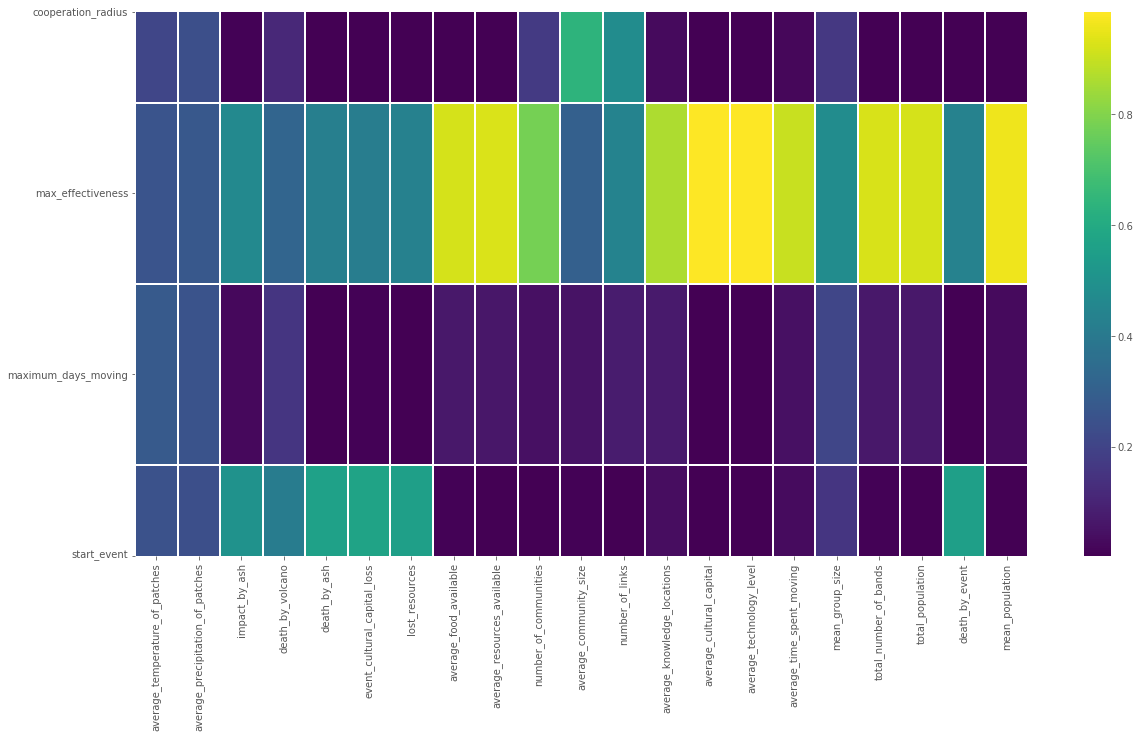

In [40]:
fs = feature_scoring.get_feature_scores_all(
    x, y, mode=RuleInductionType.REGRESSION)
fig = plt.subplots(figsize=(20, 10))

sns.heatmap(fs, cmap='viridis', linewidths=1)
pos, textvals = plt.yticks()
plt.yticks(pos, ('cooperation_radius', 'max_effectiveness', "maximum_days_moving", "start_event"), rotation=0, va="center")
plt.show()

This graph quickly shows the effect of each parameter on the KPI's. 
- Cooperation radius is an important factor for the community based KPI's, such as number of communities, community size, and number of links.
- The max effectiveness impacts almost everything, however, its biggest impact is on the cultural capital and technology levels.
- The mobility factor (maximum days moving) has a slight influence on death by volcano and the mean group size.
- The timing of the volcano impacts the impact KPI's especially.

#### 2.3.1 Total Population

In [ ]:
ax = df_climate_small.plot.scatter(x='tick',y='total_population', figsize=(20,10))
# add lines showing when the volcano erupted
ax.axvline(x=60) 
ax.axvline(x=120)
plt.show()

Quick plot that shows the distribution of the total population in the model. Few things to notice from this graph:
- The initial collapse of the population (around 10 ticks) is most-likely due to an unstable population spawn, in which the hunter-gatherer bands are set up in unlivable conditions. 
- For the temperature trend: the ice age starts around 125 ticks, which this model shows with a decreased population growth. As you can see, it was set to rise more, however, due to the ice age this growth has either decreased or limited.
- There are two big trends visible: one in which the population is stable and continues to rise and one where the population fall into a decrease.
- Around 60 and 120 ticks there are certain subsets that dropped in population. This is most-likely caused by a volcano but we can explore this further. 

From this we can certainly explore different avenues:
- Which conditions lead to a decreasing / increasing population growth?
- What is the impact of the volcano on the population? 

##### Declining Population

In [ ]:
# Only select the runs which has a downward slope in population
run_numbers = np.sort(df_climate_small['run_number'].unique())
runs_downward_slope = []

for i in run_numbers: 
    df_run = df_climate_small[df_climate_small['run_number'] == i]
    # if the total population is lower than 10000 at around tick 50, it is a downward slope (see graph above)
    # append the run number to a list of runs with a downward slope
    if 10000 > df_run['total_population'].values[10]:
        runs_downward_slope.append(i)
        
df_climate_downward_pop = df_climate_small.loc[df_climate_small['run_number'].isin(runs_downward_slope)]

In [ ]:
# Check if all these runs are in a downward slope
df_climate_downward_pop.plot.scatter(x='tick',y='total_population',c='run_number',colormap='plasma', figsize=(20,10))
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,14))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

sns.boxplot(data = df_climate_downward_pop, x='max_effectiveness',y='total_population', ax = ax1)
plt.title("Impact Max Effectiveness on Total Population")

sns.boxplot(data = df_climate_downward_pop, x='cooperation_radius',y='total_population', ax = ax2)
plt.title("Impact Cooperation Radius on Total Population")

sns.boxplot(data = df_climate_downward_pop, x='maximum_days_moving',y='total_population', ax = ax3)
plt.title("Impact Maximum Days Moving on Total Population")
plt.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,14))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

sns.boxplot(data = df_climate_small, x='max_effectiveness',y='total_population', ax = ax1)
plt.title("Impact Max Effectiveness on Total Population")

sns.boxplot(data = df_climate_small, x='cooperation_radius',y='total_population', ax = ax2)
plt.title("Impact Cooperation Radius on Total Population")

sns.boxplot(data = df_climate_small, x='maximum_days_moving',y='total_population', ax = ax3)
plt.title("Impact Maximum Days Moving on Total Population")
plt.tight_layout()
plt.show()

We can see that a low max_effectiveness (2) causes a declining population! What this means is that they are unable to gather food and resources to properly sustain themselves, the tipping point between a growing or declining population could be between 2 and 6. 



##### Impact Volcano on Population

The previous analysis showed what was the cause of a declining population. In this analysis we can quickly show what the effect is of the Laacher See Volcano on an increasing and a declining population. In the experiment setup there are three possibilites: eruption at tick 60, 120, or 240 (never). To achieve this, we take the mean population of the entire run and compare across the three scenarios.

In [ ]:
df_climate_upward_pop = df_climate_small.loc[~df_climate_small['run_number'].isin(runs_downward_slope)]
# Check if all these runs are in a upward slope
# df_climate_upward_pop.plot.scatter(x='tick',y='total_population',c='run_number',colormap='plasma', figsize=(20,10))

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

sns.boxplot(data = df_climate_downward_pop, x='start_event',y='mean_population', ax = ax1)
plt.title("Volcano Scenarios on the population mean of a decreasing population")

sns.boxplot(data = df_climate_upward_pop, x='start_event',y='mean_population', ax = ax2)
plt.title("Volcano Scenarios on the population mean of an increasing population")
fig.tight_layout()
plt.show()

From these boxplots we can see that an early volcano eruption eruption can lower the mean population in the area. This effect is stronger with an increasing population because an offset due to the volcano lowers the growth of the population. We can see that in both declining and increasing populations no volcano eruption leads to a higher mean population. 

#### 2.3.2 Cultural Capital & Technology Level

In [ ]:
ax1 = sns.lineplot(x="tick", y="average_cultural_capital", data=df_climate_small, label = "Cultural Capital")
ax2 = sns.lineplot(x="tick", y="average_technology_level", data=df_climate_small, ax = ax1, label = "Technology Level")
plt.title("Average cultural capital and technology level over time")
plt.ylabel('Cultural Capital and Technology Level')
plt.show()

What is notciable from this graph is that the cultural capital and technology level continue to grow until they have reached a stable position, it is very similar to the cumulative exponential distribution function. There seems to be a gap between the cultural capital and technology level as not every band is able to fulfill their potential because of lack of resources.

In [ ]:
fig = plt.figure(figsize=(12,16))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

sns.boxplot(data = df_climate_small, x='max_effectiveness',y='average_technology_level', ax = ax1)
plt.title("Impact Max Effectiveness on Average Technology Level")

sns.boxplot(data = df_climate_small, x='cooperation_radius',y='average_technology_level', ax = ax2)
plt.title("Impact Cooperation Radius on Average Technology Level")

sns.boxplot(data = df_climate_small, x='maximum_days_moving',y='average_technology_level', ax = ax3)
plt.title("Impact Maximum Days Moving on Average Technology Level")

sns.boxplot(data = df_climate_small, x='start_event',y='average_technology_level', ax = ax4)
plt.title("Impact Start Event on Average Technology Level")

plt.tight_layout()
plt.show()

The boxplots mostly show that max effectiveness has an impact on the average technology level, namely a low effectiveness causes the technology level to be higher than in other situations. This mostly comes from because hunter-gatherer bands who have a low technology level already died out because they are not as efficient. 

#### 2.3.3 Knowledge Locations

#### 2.3.4 Movements

#### 2.3.5 Clusters

#### 2.3.6 Compound Event Impact

In [ ]:
# Scenario Discovery of scenarios with the highest number of deaths

# Specific ema_workbench functions
from ema_workbench.analysis import prim, dimensional_stacking, cart

In [ ]:
# Only count the values of dead bands at the end of a run
df_climate_small_volcano = df_climate_small[~df_climate_small["start_event"].isin([240])]
df_climate_small_volcano_end = df_climate_small_volcano[df_climate_small["tick"].isin([240])]

In [ ]:
df_climate_small_volcano_end['death_by_event'].hist()
plt.title("Histogram of dead bands caused by the volcano")
plt.ylabel("Number of Runs")
plt.xlabel("The number of dead bands")
plt.show()

Interesting enough, there is a huge number of runs where the volcano had a very low or even non-existing impact on the population. This requires us to split the dataset into two because both the low and high values are very interesting to look at. What we already can do is filter out the scenarios where the volcano did not erupt (start_event = 240) and see if there is still a huge number of runs with 0 deaths.

Nice! It managed to reduce the number of runs where no deaths have occured but it still occurs at a very high frequency. Lets use the Patient Rule Induction Method to take a quick look at scenarios in which this occured

In [ ]:
df_climate_small.columns

In [ ]:
# Set series up to look at scenarios where the number of deaths are higher than 0
x = df_climate_small_volcano_end[['max_effectiveness', 'cooperation_radius',
       'maximum_days_moving', 'start_event']]  # Only take the parameters

y_deaths = df_climate_small_volcano_end['death_by_event'].values
y_deaths = y_deaths > 0

In [ ]:
prim_alg = prim.Prim(x, y_deaths, threshold=0.65, peel_alpha=0.1)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()

In [ ]:
box1.inspect(1)

Unfortunately, PRIM did not give us very convincing answers. We are not able to say for certain what is the reason for number of deaths, however, there is a high occurance rate if the max effectiveness is set above 6, the coverage (recall) is then around 67% with a density (precision) of 1. Ultimately, it seems that from the set of parameters a high effectiveness will most-likely cause the most deaths. This can be explained that a high effectiveness would also mean a high population.

Lets look at the effect of the volcano on population! Because it is very probable that they are impacted, however, that they do not necessarily die out if they are able to move.

In [ ]:
df_climate_small_volcano["impact_by_ash"].hist()

In [ ]:
# Set series up to look at scenarios where the number of deaths are higher than 0
y_impact = df_climate_small_volcano['impact_by_ash'].values
y_impact = y_impact > 0

In [ ]:
prim_alg = prim.Prim(x, y_deaths, threshold=0.65, peel_alpha=0.1)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()

In [ ]:
df_climate_small.groupby(df_climate_small['run_number']).boxplot(column=['total_population','death_by_event','average_time_spent_moving'],figsize=(40,40))

In [ ]:
# Let's make another scatterplot, now let's look at grass vs sheep
df_climate_small.plot.scatter(x='max_effectiveness',y='average_cultural_capital',figsize=(20,10))

In [ ]:
df_climate_small.plot.scatter(x='tick',y='average_cultural_capital',c='run_number',colormap='viridis', figsize=(15,8))

In [ ]:
df_climate_small.plot.scatter(x='tick',y='total_population',c='run_number',colormap='viridis',figsize=(20,10))